# Oystercatchers Model

In [42]:
# model.py
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
import random

class OysterCatcher(Agent):
    """ A foraging agent with initial reserve."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.reserve = 100

    def move(self):
        x, y = self.pos
        
        dx = 1 + int( random.expovariate(lambd=1) ) # see section 2; is there a better one?
        dy = 1 + int( random.expovariate(lambd=1) )
        
        if random.randint(0,1):
            dx = - dx
        if random.randint(0,1):
            dy = - dy
        #possible_steps = self.model.grid.get_neighborhood(
        #    self.pos,
        #    moore=True, # Moore setting means diagnonals can be used too
        #    include_center=False, radius=radius) # centre won't be revisited; radius sets distance travelled
        #new_position = random.choice(possible_steps) # so even if distant sites are included you may end up close
        new_position = (x + dx, y + dy) # what if we go over perimeter? set toroidal for now
        self.model.grid.move_agent(self, new_position)
        
    def donate_reserve(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        print(cellmates)
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.reserve += int(self.reserve / 2) # approximately half given away
            self.reserve -= int(self.reserve / 2)

    def step(self):
        self.move()
        if self.reserve > 0:
            self.donate_reserve()

## Thoughts: could have limpets as agents
## Seems easier to have them as simplest possible representation
## Perhaps distribute M limpet agents in the ForageModel during __init__
## For eating (to replace donate_reserve()) we then need method for looking at limpets only

def Limpet(Agent):
    """ A food source with variable calorific value."""
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.pos = pos
        self.size = 10
        
    def step(self):
        pass
        
def compute_gini(model):
    agent_wealths = [agent.reserve for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class ForageModel(Model):
    """A model with some number of agents."""
    def __init__(self, n_limpets, n_birds, width, height):
        self.running = True # this was important for visualization
        self.n_limpets = n_limpets
        self.n_birds = n_birds
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, torus=True) # True means toroidal space (for now)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.n_limpets):
            coords = (random.randrange(self.grid.width), random.randrange(self.grid.height))
            agent = Limpet(coords) # i, self
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords)

        for i in range(self.n_birds):
            agent = OysterCatcher(i, self)
            self.schedule.add(agent)

            # Add the agent to a random grid cell
            coords = (random.randrange(self.grid.width), random.randrange(self.grid.height))
            self.grid.place_agent(agent, coords)
            
        self.dc = DataCollector(
            model_reporters={"agent_count": lambda m: m.schedule.get_agent_count() , "gini": compute_gini},
            agent_reporters={"name": lambda a: a.unique_id , "reserve": lambda a: a.reserve}
        )

    def step(self):
        '''Advance the model by one step.'''
        self.dc.collect(self)
        self.schedule.step()

In [43]:
# run.py
model = ForageModel(10, 5, 20, 30) # based on meters of site (200 by 30)
for i in range(100):
    model.step()
model_df = model.dc.get_model_vars_dataframe()
agent_df = model.dc.get_agent_vars_dataframe()

AttributeError: 'NoneType' object has no attribute 'pos'

In [3]:
model_df.tail()

,agent_count,gini
95,5,0.2
96,5,0.2
97,5,0.2
98,5,0.2
99,5,0.2


In [4]:
agent_df.tail()

name  reserve
Step AgentID               
99   0           0       50
     1           1       75
     2           2       75
     3           3      150
     4           4      100

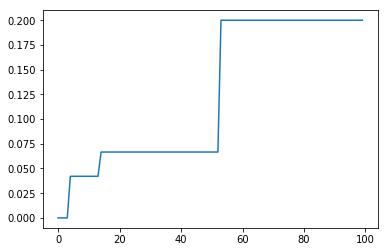

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
gini = model_df['gini']
gini.plot()

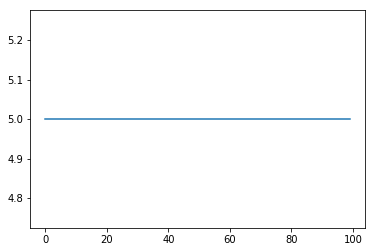

In [14]:
agent_count = model_df['agent_count']
agent_count.plot()

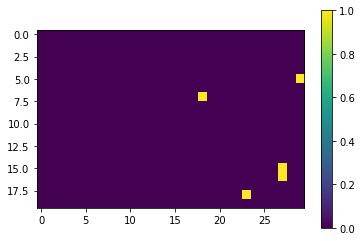

In [15]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [16]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 20, 30, 500, 500)
server = ModularServer(ForageModel,
                       [grid],
                       name="OysterCatcher Model",
                       model_params={"n_agents": 5, "width": 20, "height": 30})
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: [Errno 48] Address already in use

Socket opened!
{"type":"get_params"}
{"type":"reset"}
Socket opened!
{"type":"get_params"}
{"type":"reset"}
{"type":"get_step","step":1}


In [62]:
ModularServer?

# Distributions (+ Play Code)

Thinking about movement biased towards just one square:

(array([6.363e+03, 2.306e+03, 8.200e+02, 3.200e+02, 1.200e+02, 3.900e+01,
        1.400e+01, 1.000e+01, 4.000e+00, 4.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

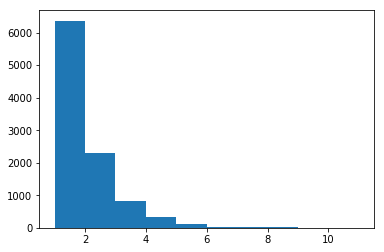

In [5]:
coll = []
for i in range(10000):
    coll.append(1+int(random.expovariate(lambd=1)))
plt.hist(coll)

Let's make a 50:50 contigency:

In [6]:
if random.randint(0,1):
    print("me")

me


Find out a little more about some Mesa terms

In [7]:
model.grid.coord_iter?

In [8]:
MultiGrid.get_neighborhood?

Simple maths:

In [9]:
i=4
i /= 2
print(i)

2.0


Can we do something with binomial?

(array([3530., 3803.,    0., 1963.,    0.,  579.,  104.,    0.,   16.,
           5.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

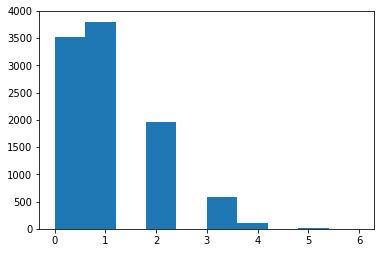

In [10]:
coll = np.random.binomial(n=10, p=0.1, size=10000)
plt.hist(coll)